In [23]:
import os
import sys
import pickle
import random
from itertools import product
from datetime import datetime, date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.preprocessing import minmax_scale, scale, StandardScaler
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import adfuller, coint, grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import VECM, select_order, select_coint_rank, coint_johansen

sys.path.append(f"{os.getcwd()}/../")

from src.data.processing.utils import CleanUp, SNOWBALL_STEMMER
from src.database.models import RawHashtagComments, UserLocation

sns.set(style="darkgrid")
%matplotlib inline


def test_4_stationary(X):
    result = adfuller(X)
    pvalue = result[1]
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % pvalue)
    print('Critical Values:')
    for key, value in result[4].items():
        print(' - %s: %.3f' % (key, value))
    print(f"Is the time series stationary? {pvalue < 0.05}")
    return pvalue < 0.05


def test_4_cointegration(y1, y2, verbose=True):
    result, pvalue_final, maxlag_final, trend_final = None, 1.0, 1, 'nc'
    for trend, maxlag in product(['c', 'ct', 'ctt'], range(1, 30)):
        try:
            result_p = coint(y1, y2, trend=trend, maxlag=maxlag)
            pvalue = result_p[1]
            if pvalue_final > pvalue:
                pvalue_final = pvalue
                maxlag_final = maxlag
                trend_final = trend
                result = result_p
        except:
            pass
    
    pvalue = result[1]
    if verbose:
        print('Cointegration Statistic: %f' % result[0])
        print('p-value: %f' % pvalue)
        print('Critical Values:')
        for key, value in zip([1, 5, 10], result[2]):
            print(f' - {key}%: {round(value, 3)}')
        print(f"Is time series cointegrate? {pvalue < 0.05}")
    return pvalue < 0.05, maxlag_final, trend_final

def check_time_series(y1, y2, columns):
    print("Augmented Dickey-Fuller Test:")
    print("-" * 30)
    print()

    print(f"{columns[0]}:")
    print("-" * 30)
    y1_is_stationary = test_4_stationary(y1)

    print()
    print(f"{columns[1]}:")
    print("-" * 30)
    y2_is_stationary = test_4_stationary(y2)
    
    print()
    print()
    print("Engle-Granger Test:")
    print("-" * 30)
    is_cointegrate, maxlag, trend = test_4_cointegration(y1, y2)


def autoregression_model(y1, y2, columns):
    y1_is_stationary = adfuller(y1)[1] < 0.05
    y2_is_stationary = adfuller(y2)[1] < 0.05
    is_cointegrate, _, trend = test_4_cointegration(y1, y2, verbose=False)
    
    result = None
    df_int_ = pd.DataFrame(np.c_[y1, y2], columns=columns)
    # VECM
    if is_cointegrate:
        if trend == 'c':
            trend == 'ci'
        elif trend == 'ct':
            trend == 'li'
        elif trend == 'ctt':
            trend = 'cili'
        
        print("Vector Error Correction Models (VECM):")
        print("-" * 30)
        maxlag = 15
        try:
            lag_order = select_order(df_int_, maxlags=maxlag, deterministic=trend)
        except:
            lag_order = select_order(df_int_, maxlags=7, deterministic=trend)
        maxlag = lag_order.selected_orders['aic']
        rank_test = select_coint_rank(df_int_, -1, 15, method="trace")
        coint_rank = rank_test.rank
        print(f"Lag: {maxlag}")
        print(f"Trend: {trend}")
        print(f"Cointegration: {coint_rank}")
        print()
        result = VECM(df_int_, k_ar_diff=maxlag, coint_rank=coint_rank, deterministic=trend).fit()
        print(result.test_granger_causality(caused=columns[1], causing=columns[0]).summary())
        print()
        print()
        print(result.test_inst_causality(causing=columns[0]).summary())
    # VAR
    elif (y1_is_stationary and y2_is_stationary):
        print("Vector Autoregressions (VAR):")
        print("-" * 30)
        model = VAR(df_int_)
        lag_order = model.select_order(20)
        lag_order_val = lag_order.selected_orders['aic']
        maxlag = maxlag if maxlag >= lag_order_val else lag_order_val
        print(f"Lag: {maxlag}")
        print(f"Trend: {trend}")
        print()
        result = model.fit(ic="aic", maxlags=maxlag, trend=trend)
        print(result.test_causality(caused=columns[1], causing=columns[0]).summary())
        print()
        print()
        print(result.test_inst_causality(causing=columns[0]).summary())
    else:
        print("!!! Can find a model that could fit the series, please make the series stationary !!!")
    if result:
        result.plot_forecast(steps=3)
    return result
    

def gerar_graficos(x1, x2, datas, columns, steps=5, scale_data=True, cummulative=False):
    # x1 = x1 / 212_000_000
    # x2 = (x2 * 0.75) / 8_600_000
    
    x1_scale = x1
    x2_scale = x2
    if scale_data:
        x1_scale = scale(x1)
        x2_scale = scale(x2)
    mmin, mmax = np.min([np.min(x1_scale), np.min(x2_scale)]), np.max([np.max(x1_scale), np.max(x2_scale)])

    if cummulative:
        cumsum_x1 = np.cumsum(x1)
        cumsum_x2 = np.cumsum(x2)
        if scale_data:
            cumsum_x1 = scale(cumsum_x1)
            cumsum_x2 = scale(cumsum_x2)
        cmmin, cmmax = np.min([np.min(cumsum_x1), np.min(cumsum_x2)]), np.max([np.max(cumsum_x1), np.max(cumsum_x2)])

    tempo = np.arange(1, len(datas) + 1)
    numero_tempo = list(np.arange(1, len(datas), steps))
    numero_tempo = numero_tempo + [max(numero_tempo) + (steps - 1)]
    data_tempo = list(datas[::steps]) + [datas[-1]]
    
    try:
        idx_saida_mandetta = np.where(datas == date(2020, 4, 16))[0][0] + 1
        idx_saida_moro = np.where(datas == date(2020, 4, 24))[0][0] + 1
        idx_5000 = np.where(datas == date(2020, 4, 28))[0][0] + 1
    except:
        pass
    
    try:
        idx_saida_teich = np.where(datas == date(2020, 5, 15))[0][0] + 1
        idx_manifestacao = np.where(datas == date(2020, 5, 31))[0][0] + 1
        idx_flexibilizacao = np.where(datas == date(2020, 6, 10))[0][0] + 1
    except:
        pass
    
    plt.figure(figsize=(15, 12))
    plt.subplot(2, 1, 1)
    plt.title(f"Comparativo : {columns[0]} x {columns[1]} : Brasil")
    plt.plot(tempo, x1_scale, label=columns[0])
    plt.plot(tempo, x2_scale, label=columns[1])
    try:
        plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
        plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
        plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
    except:
        pass
    try:
        plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
        plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
        plt.plot([idx_flexibilizacao, idx_flexibilizacao], [mmin, mmax], "--", c="#03a9f4", label="Flexibilização quarentena")
    except:
        pass
    plt.xticks(numero_tempo, data_tempo, rotation=75)
    plt.xlabel("Data")
    plt.ylabel("Quantidade")
    plt.legend()

    if cummulative:
        plt.subplot(2, 1, 2)
        plt.title(f"Comparativo : {columns[0]} x {columns[1]} : Soma Acumulada : Brasil")
        plt.plot(tempo, cumsum_x1, label=columns[0])
        plt.plot(tempo, cumsum_x2, label=columns[1])
        try:
            plt.plot([idx_saida_mandetta, idx_saida_mandetta], [mmin, mmax], "--", c="#3f51b5", label="Saída Mandetta")
            plt.plot([idx_saida_moro, idx_saida_moro], [mmin, mmax], "--", c="#4caf50", label="Saída Moro")
            plt.plot([idx_5000, idx_5000], [mmin, mmax], "--", c="#e91e63", label="5k Mortes e \"e dai?\" ")
        except:
            pass
        try:
            plt.plot([idx_saida_teich, idx_saida_teich], [mmin, mmax], "--", c="#9c27b0", label="Saída Teich")
            plt.plot([idx_manifestacao, idx_manifestacao], [mmin, mmax], "--", c="#cddc39", label="Manifestação antifacismo")
            plt.plot([idx_flexibilizacao, idx_flexibilizacao], [mmin, mmax], "--", c="#03a9f4", label="Flexibilização quarentena")
        except:
            pass
        plt.xticks(numero_tempo, data_tempo, rotation=75)
        plt.xlabel("Data")
        plt.ylabel("Acumulado")
        plt.legend()
    
    plt.tight_layout()
    plt.show()
    return x1_scale, x2_scale

In [3]:
df_covid = pd.read_csv("https://raw.githubusercontent.com/rdenadai/covid19statistics/master/data/covid-19/brazil/cases-brazil-cities-time-2020-06-27.csv")
# print(df_covid.columns)

In [4]:
df_covid = df_covid.drop(df_covid.index[df_covid["state"] == "TOTAL"])

In [5]:
covid_data = df_covid[["date", "newCases", "newDeaths"]].copy()
covid_data["date"] = pd.to_datetime(covid_data["date"], format='%Y-%m-%d')
covid_data = covid_data.groupby([covid_data["date"].dt.date]).sum().reset_index()
# covid_data

In [6]:
hashtags_ = pd.DataFrame(list(RawHashtagComments.select().dicts()))
hashtags_ = hashtags_.drop(["hash"], axis=1)
hashtags_["count"] = 1
hashtags_["date"] = hashtags_['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
hashtags_ = hashtags_[hashtags_["date"] > pd.Timestamp(2020, 1, 1)]

users_ = pd.DataFrame(list(UserLocation.select().dicts()))

In [7]:
# print(hashtags_.columns)
# print(users_.columns)

## Verificação de Causalidade

Lembrando as perguntas as quais deseja-se responder sobre essa análise:

 - É possível identificar a disseminação da COVID-19 no Brasil, através do conteúdo de redes sociais?
 - Sendo possível:
  - Com que grau de certeza a disseminação de COVID-19 é identificada?
  - Com que antecedência podemos identificar a disseminação da doença (em dias/semanas)?
  - Considerando que boa parte do conteúdo extraído não terá informações de geolocalização, é possível verificar essa disseminação por cidades ou estados?
  
Neste sentido, será necessário validar as séries temporais da quantidade de comentários ao longo de determinado período e a de Novo Casos / Mortes ao longo da pandemia.

Para esta análise, foi definido alguns limites:

 - Será feito uma análise do período todo de coleta.
  - Com relação a análise do período todo, é importante notar que a quantidade de comentários no Twitter da um grande salto a partir do dia 05/05, dessa maneira, será realizada uma análise deste período em diante para verificar se existe alguma modificação na relação causal.
 - Como visto acima, será selecionado apenas a análise dos estados de São Paulo e Rio de Janeiro por possuirem maior quantidade de comentários.

Estima-se que exite cerca de 8 milhões e 280 mil usuários no Twitter, entretanto no Brasil, tem-se aproximadamente 212 milhões de habitantes. Visto essa discrepância na quantidade de pessoas, para uma análise mais direcionada, os dados serão estandardizados:

$z = \frac{(x - \mu)}{\sigma}$

Após isso, para a análise de série temporais leva em consideração alguns aspectos.

A análise deve levar em consideração se as séries são estacionárias ou não. Sendo ambas estacionárias pode-se usar o modelo VAR (Vector Autoregression), que através deste pode-se validar a causalidade de Granger e instantânea entre as séries, além da possibilidade de predição (forecast).

Caso ambas as séries não sejam estacionárias, é válida a verificação se as mesmas são cointegradas, e se forem utiliza-se o modelo VECM (Vector Error Correction Models) permitindo a mesma validação que a apresentada pelo modelo VAR.

Se mesmo assim, não for possível aplicar nenhum do dois modelos, uma outra tentativa é transformar as séries (removendo um pequeno atraso (1 dia)) para que se tornem estacionárias. Feito isso o modelo VAR pode ser aplicado.

Para a verificar se as séries são estacionárias, é possível usar o teste de Dickey-Fuller, que verifica se as séries possuem raiz unitária.

No caso da verificação para validar se as séries são cointegradas, utiliza-se o teste de Engle-Granger.

### Período Completo

Como primeira análise, será aplicado o mencionado acima, na série temporal toda desde o "começo" da pandemia.

#### Novos Casos x Comentários Positivos

In [8]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

# df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
# df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
# df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
# df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
# df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
# df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

Matriz de correlacao entre as variaveis:

In [9]:
print(df_merged[["newCases", "newDeaths", "numComments"]].corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.909656     0.738977
newDeaths    0.909656   1.000000     0.812864
numComments  0.738977   0.812864     1.000000


Antes de realizar todo o procedimento mencionado acima vamos observar os dados em seus estados brutos.

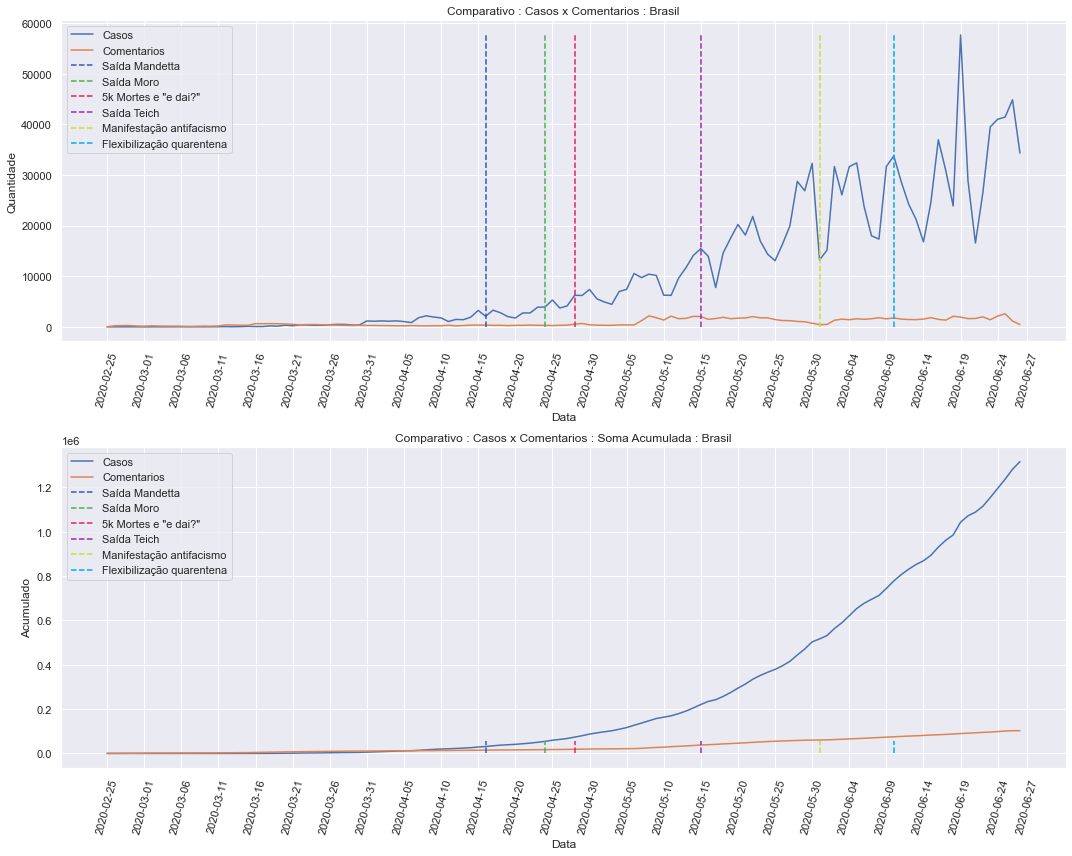

In [10]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"], scale_data=False, cummulative=True)

In [11]:
check_time_series(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.520519
p-value: 0.523337
Critical Values:
 - 1%: -3.489
 - 5%: -2.887
 - 10%: -2.580
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 2.494451
p-value: 0.999048
Critical Values:
 - 1%: -3.491
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? False


Engle-Granger Test:
------------------------------
Cointegration Statistic: -4.262600
p-value: 0.002926
Critical Values:
 - 1%: -3.988
 - 5%: -3.386
 - 10%: -3.079
Is time series cointegrate? True


Vector Error Correction Models (VECM):
------------------------------
Lag: 15
Trend: c
Cointegration: 0

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         4.332          1.713   0.000 (16, 146)
-----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.5529          3.841   0.457  1
----------------------------------------


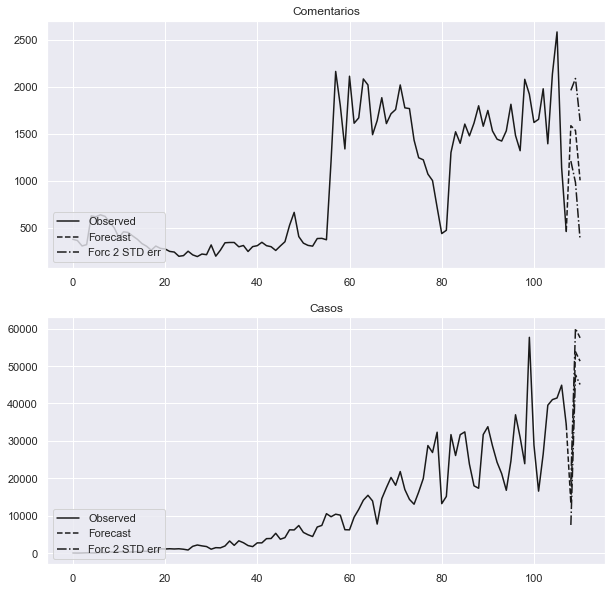

In [12]:
autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Utilizando parte dos dados, para verificar qual o resultado, se existe causalidade de Granger em espaços de tempo.

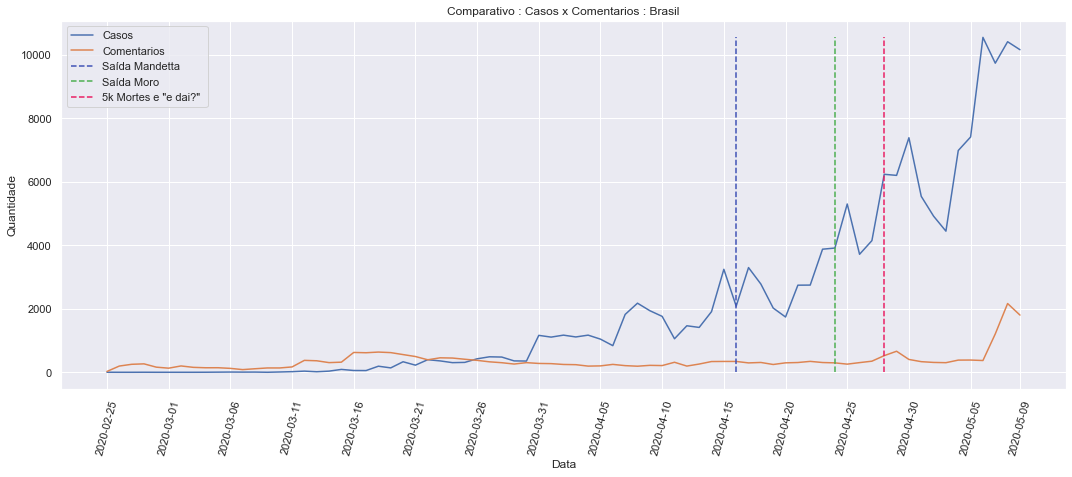

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -0.622812
p-value: 0.865744
Critical Values:
 - 1%: -3.525
 - 5%: -2.903
 - 10%: -2.589
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 5.773138
p-value: 1.000000
Critical Values:
 - 1%: -3.541
 - 5%: -2.909
 - 10%: -2.592
Is the time series stationary? False


Engle-Granger Test:
------------------------------
Cointegration Statistic: -3.486685
p-value: 0.033594
Critical Values:
 - 1%: -4.051
 - 5%: -3.42
 - 10%: -3.102
Is time series cointegrate? True
Vector Error Correction Models (VECM):
------------------------------
Lag: 14
Trend: c
Cointegration: 0

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.083          1.856   0.393 (15, 54)
--

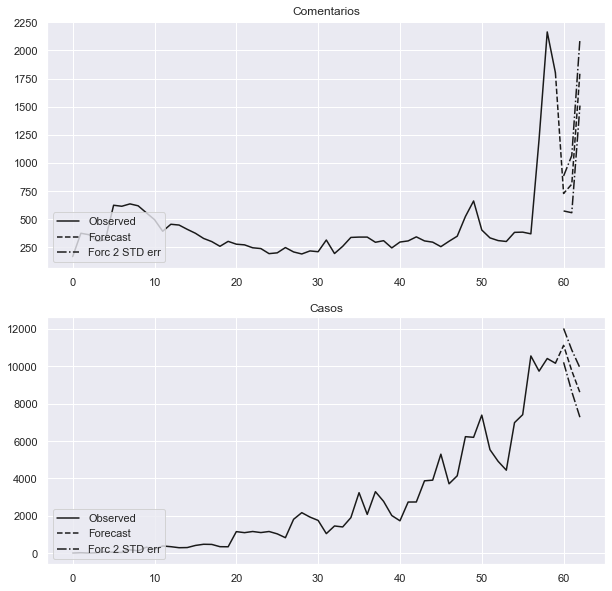

In [32]:
df_merged_period = df_merged[(df_merged['date'] > pd.Timestamp(2020, 2, 15)) & (df_merged['date'] < pd.Timestamp(2020, 5, 10))]
datas_period = df_merged_period["date"].to_numpy()

x1, x2 = gerar_graficos(df_merged_period["newCases"], df_merged_period["numComments"], datas_period, ["Casos", "Comentarios"], scale_data=False, cummulative=False)
check_time_series(x2, x1, columns=["Comentarios", "Casos"])
autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

Conforme mencionado, as escalas dos dados sao realmente diferentes, isso devido ao fato da quantidade de usuarios brasileiros no Twitter ser bem inferior a quantidade total da populacao brasileira (calcula-se que haja em torno de pouco mais de 8 milhoes).

Sendo assim, realiza-se a estandartizacao dos dados, e novamente apreseta-se a relacao entre eles.

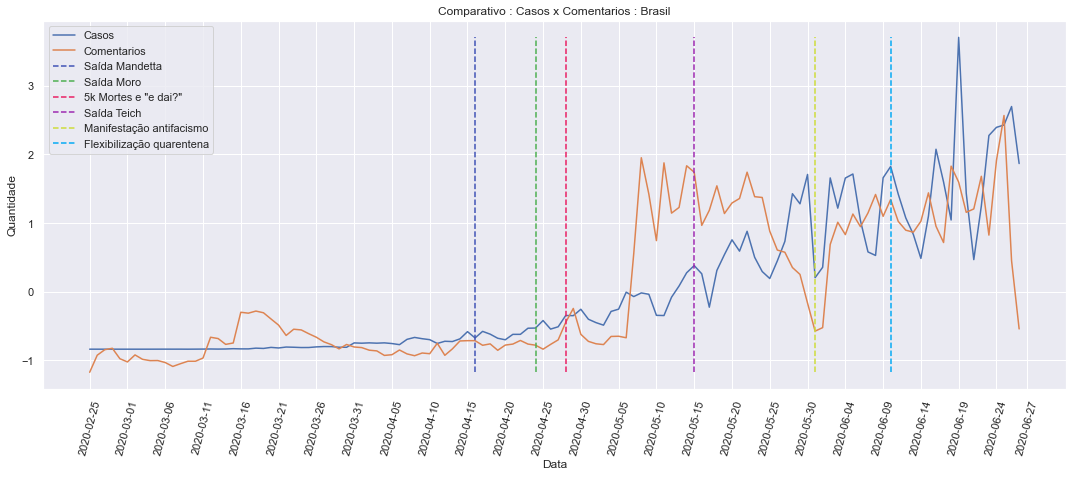

In [147]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

In [148]:
check_time_series(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.520519
p-value: 0.523337
Critical Values:
 - 1%: -3.489
 - 5%: -2.887
 - 10%: -2.580
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 2.494451
p-value: 0.999048
Critical Values:
 - 1%: -3.491
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? False


Engle-Granger Test:
------------------------------
Cointegration Statistic: -4.262600
p-value: 0.002926
Critical Values:
 - 1%: -3.988
 - 5%: -3.386
 - 10%: -3.079
Is time series cointegrate? True


Vector Error Correction Models (VECM):
------------------------------
Lag: 15
Trend: c
Cointegration: 0

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         3.734          1.713   0.000 (16, 146)
-----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.5088          3.841   0.476  1
----------------------------------------


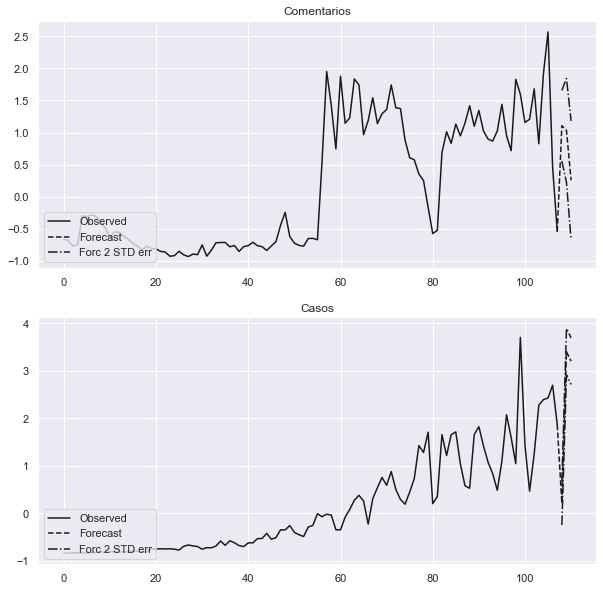

In [149]:
autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

#### Mortes x Comentários Positivos

Dando sequência as validações, faz-se a verificação se os comentários no Twitter possuem uma relação "causal" na quantidade de mortes que ocorrem.

Observa-se inicialmente a relacao dos dados sem a estandartizacao... 

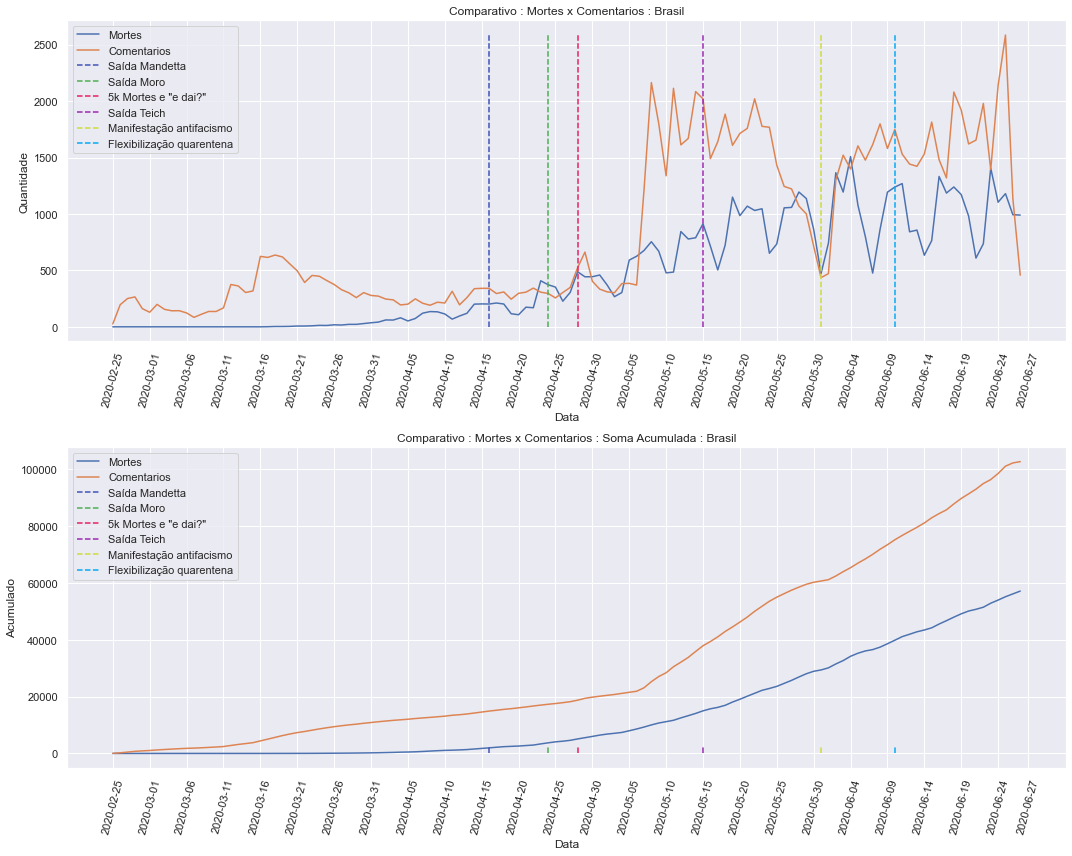

In [150]:
 x1, x2 = gerar_graficos(df_merged["newDeaths"], df_merged["numComments"], datas, ["Mortes", "Comentarios"], scale_data=False, cummulative=True)

E possivel notar, que no caso das mortes, os valores estao bem proximos, nao havendo necessidade de estandartizacao, entretanto, para manter o mesmo procedimento como o dos novos casos, abaixo aplica-se o mesmo procedimento.

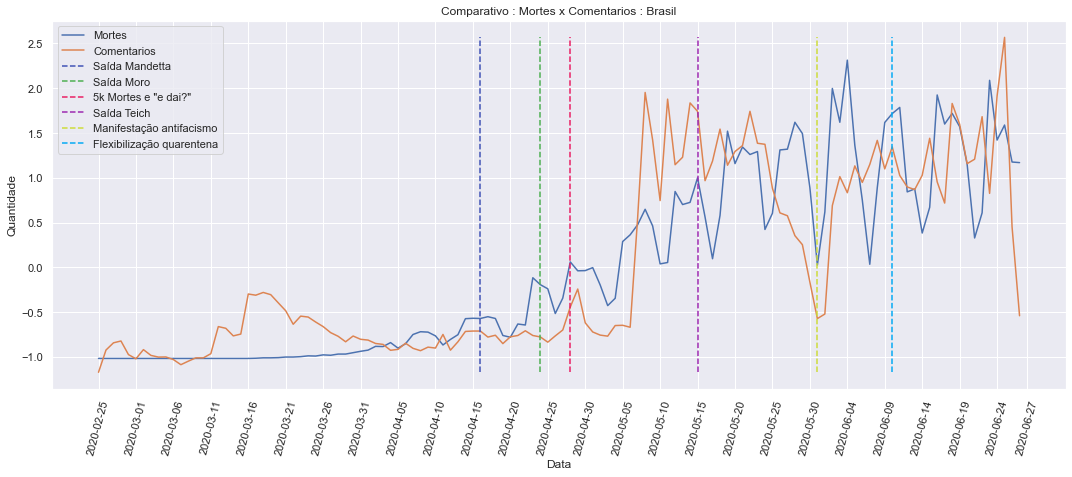

In [151]:
x1, x2 = gerar_graficos(df_merged["newDeaths"], df_merged["numComments"], datas, ["Mortes", "Comentarios"])

In [152]:
check_time_series(x2, x1, columns=["Comentarios", "Mortes"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.520519
p-value: 0.523337
Critical Values:
 - 1%: -3.489
 - 5%: -2.887
 - 10%: -2.580
Is the time series stationary? False

Mortes:
------------------------------
ADF Statistic: -0.181341
p-value: 0.940709
Critical Values:
 - 1%: -3.491
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? False


Engle-Granger Test:
------------------------------
Cointegration Statistic: -5.184400
p-value: 0.000074
Critical Values:
 - 1%: -3.988
 - 5%: -3.386
 - 10%: -3.079
Is time series cointegrate? True


Vector Error Correction Models (VECM):
------------------------------
Lag: 15
Trend: c
Cointegration: 1

Granger causality F-test. H_0: Comentarios does not Granger-cause Mortes. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         1.975          1.713   0.018 (16, 146)
-----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Mortes. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
      0.001137          3.841   0.973  1
----------------------------------------


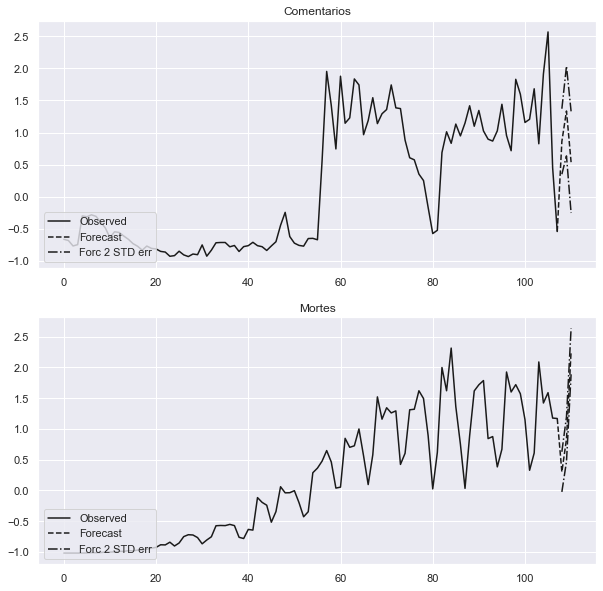

In [153]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Mortes"])

---

### Período Parcial

Conforme mencionado será analisado parte do período (a partir de 05/05).

#### Novos Casos x Comentários Positivos

In [154]:
df_dt = hashtags_[hashtags_['classify'] == 'positivo'].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 5, 5)]

df_merged = []
for idx, row in covid_data.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

Matriz de correlacao:

In [155]:
print(df_merged[["newCases", "newDeaths", "numComments"]].corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.710187     0.033283
newDeaths    0.710187   1.000000     0.080142
numComments  0.033283   0.080142     1.000000


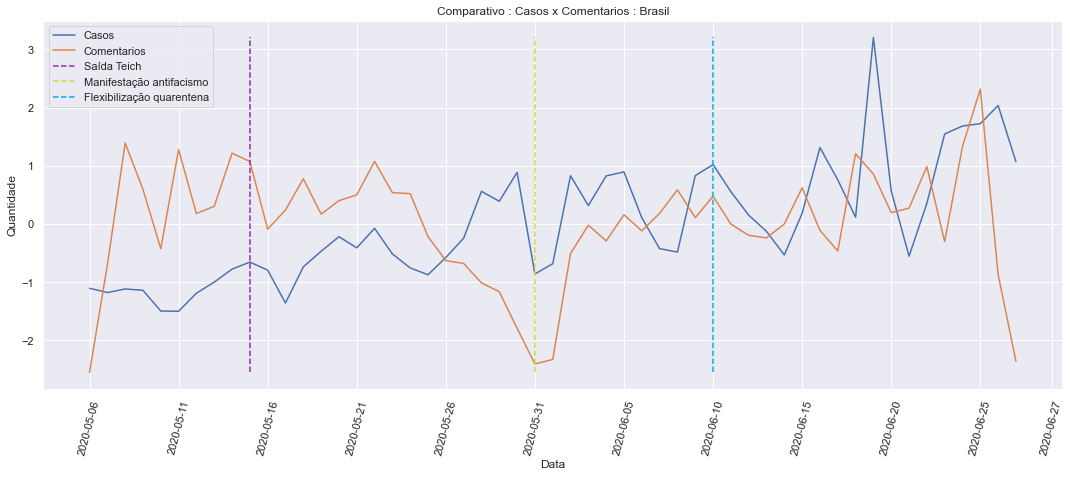

In [156]:
x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

Vector Error Correction Models (VECM):
------------------------------
Lag: 15
Trend: c
Cointegration: 2

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
     1.953e+04          5.844   0.000 (16, 4)
---------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.3615          3.841   0.548  1
----------------------------------------


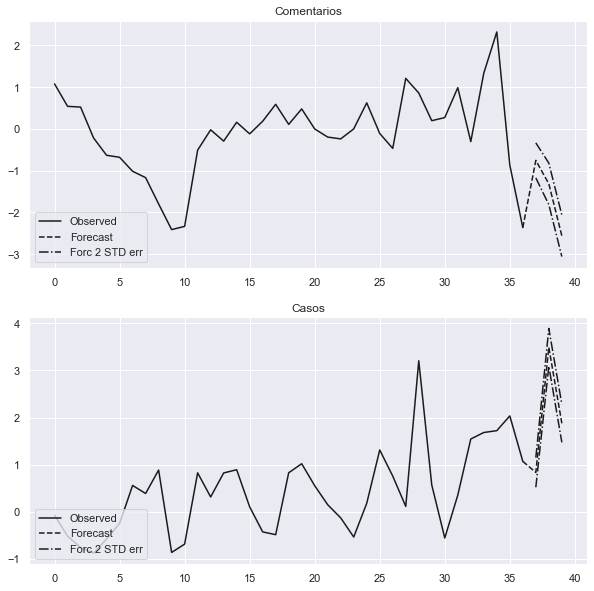

In [157]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

#### Mortes x Comentários Positivos

Dando sequência as validações, faz-se a verificação se os comentários no Twitter possuem uma relação causal na quantidade de mortes que ocorrem.

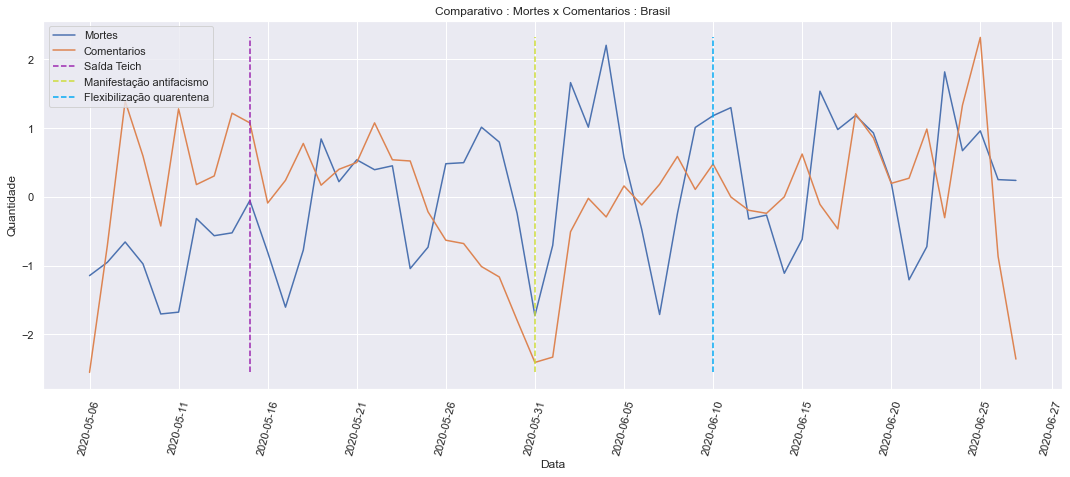

In [158]:
x1, x2 = gerar_graficos(df_merged["newDeaths"], df_merged["numComments"], datas, ["Mortes", "Comentarios"])

Vector Error Correction Models (VECM):
------------------------------
Lag: 15
Trend: c
Cointegration: 1

Granger causality F-test. H_0: Comentarios does not Granger-cause Mortes. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df  
---------------------------------------------
         12.91          5.844   0.012 (16, 4)
---------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Mortes. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.4190          3.841   0.517  1
----------------------------------------


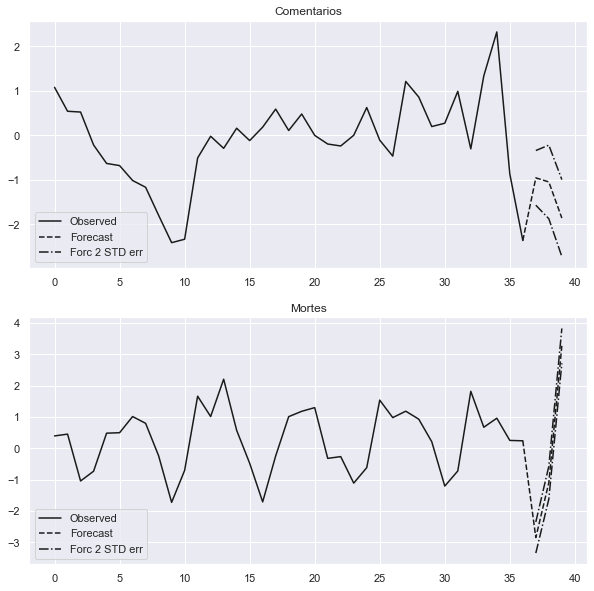

In [159]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Mortes"])

---

### Período completo por estados

#### Novos Casos x Comentários Positivos (Sao Paulo)

In [160]:
covid_data_state = df_covid[["date", "state", "newCases", "newDeaths"]].copy()
covid_data_state["date"] = pd.to_datetime(covid_data_state["date"], format='%Y-%m-%d')
covid_data_state = covid_data_state[covid_data_state["state"] == "SP"]
covid_data_state = covid_data_state.groupby([covid_data_state["date"].dt.date]).sum().reset_index()

usr = users_[users_['state'] == 'SP'].copy()
df_dt = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data_state.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

Matriz de correlacao:

In [161]:
print(df_merged[["newCases", "newDeaths", "numComments"]].corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.799783     0.512592
newDeaths    0.799783   1.000000     0.575605
numComments  0.512592   0.575605     1.000000


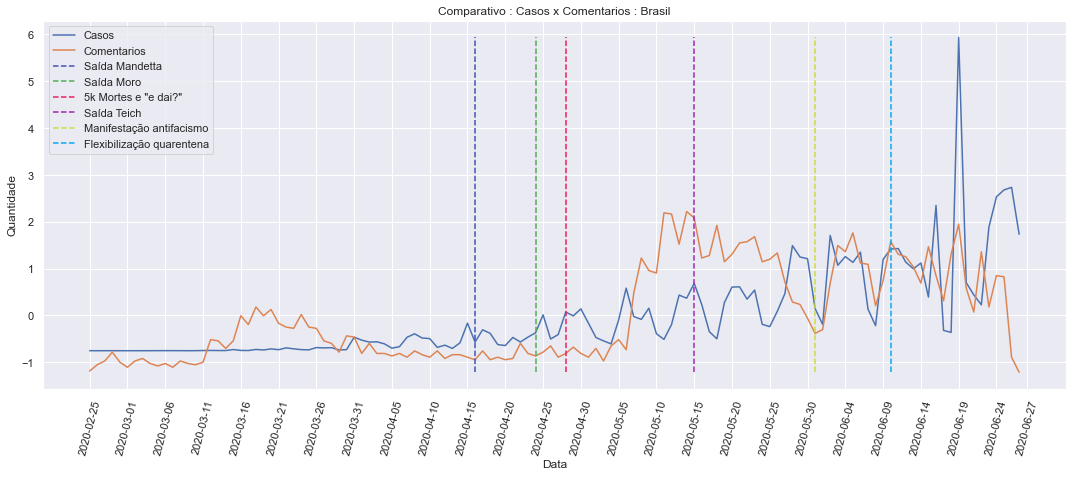

In [162]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

In [163]:
check_time_series(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.916564
p-value: 0.324310
Critical Values:
 - 1%: -3.486
 - 5%: -2.886
 - 10%: -2.580
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: 3.163011
p-value: 1.000000
Critical Values:
 - 1%: -3.491
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? False


Engle-Granger Test:
------------------------------
Cointegration Statistic: -2.756803
p-value: 0.380734
Critical Values:
 - 1%: -4.455
 - 5%: -3.859
 - 10%: -3.554
Is time series cointegrate? False


In [164]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

!!! Can find a model that could fit the series, please make the series stationary !!!


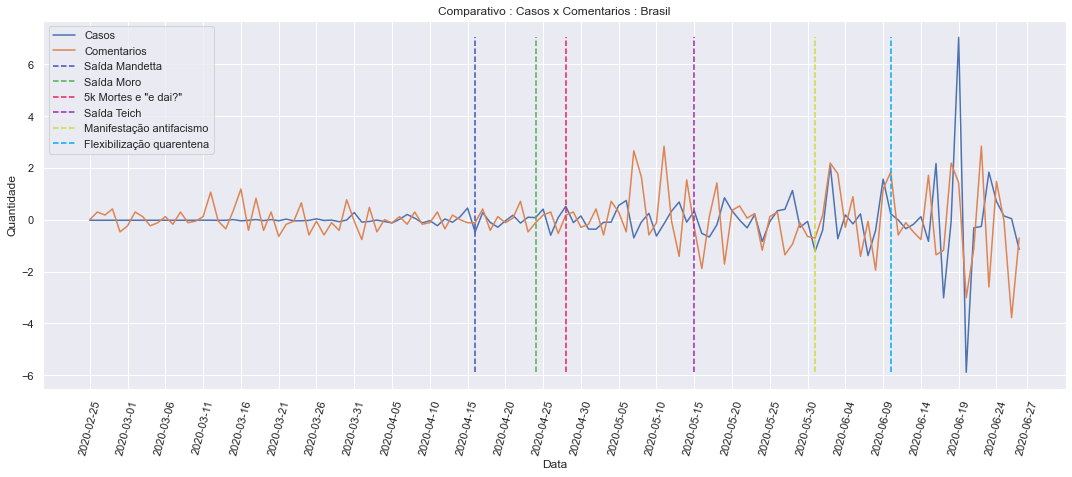

In [165]:
 x1, x2 = gerar_graficos(df_merged["stationary_newCases"], df_merged["stationary_numComments"], datas, ["Casos", "Comentarios"])

Vector Error Correction Models (VECM):
------------------------------
Lag: 12
Trend: ct
Cointegration: 1

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.645          1.780   0.002 (13, 164)
-----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.2646          3.841   0.607  1
----------------------------------------


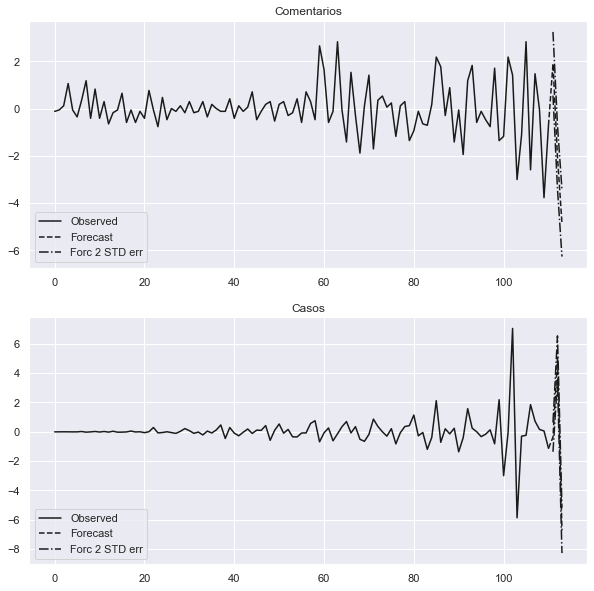

In [166]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

#### Novos Casos x Comentários Positivos (Rio de Janeiro)

In [167]:
covid_data_state = df_covid[["date", "state", "newCases", "newDeaths"]].copy()
covid_data_state["date"] = pd.to_datetime(covid_data_state["date"], format='%Y-%m-%d')
covid_data_state = covid_data_state[covid_data_state["state"] == "RJ"]
covid_data_state = covid_data_state.groupby([covid_data_state["date"].dt.date]).sum().reset_index()

usr = users_[users_['state'] == 'RJ'].copy()
df_dt = hashtags_[(hashtags_['username'].isin(usr['username'])) & (hashtags_['classify'] == 'positivo')].drop_duplicates("username").copy()
df_dt['date'] = df_dt['timestamp'].map(lambda x: datetime.strptime(x.strftime('%Y-%m-%d'), '%Y-%m-%d'))
df_dt['count'] = 1
df_dt = df_dt.groupby([df_dt['date'].dt.date]).sum().reset_index()
df_dt = df_dt[df_dt['date'] > pd.Timestamp(2020, 1, 1)]

df_merged = []
for idx, row in covid_data_state.iterrows():
    dt_search = row["date"]
    found = df_dt[df_dt["date"] == dt_search]
    if len(found) > 0:
        df_merged.append(list(row.to_numpy()) + [int(found["count"])])
df_merged = pd.DataFrame(df_merged, columns=["date", "newCases", "newDeaths", "numComments"])

df_merged['stationary_newCases'] = df_merged['newCases'] - df_merged['newCases'].shift(1)
df_merged['stationary_newDeaths'] = df_merged['newDeaths'] - df_merged['newDeaths'].shift(1)
df_merged['stationary_numComments'] = df_merged['numComments'] - df_merged['numComments'].shift(1)
df_merged['stationary_newCases'] = df_merged['stationary_newCases'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_numComments'] = df_merged['stationary_numComments'].replace([np.inf, -np.inf, np.nan], 0)
df_merged['stationary_newDeaths'] = df_merged['stationary_newDeaths'].replace([np.inf, -np.inf, np.nan], 0)

datas = df_merged["date"].to_numpy()

Matriz de correlacao:

In [168]:
print(df_merged[["newCases", "newDeaths", "numComments"]].corr())

             newCases  newDeaths  numComments
newCases     1.000000   0.639336     0.549667
newDeaths    0.639336   1.000000     0.695074
numComments  0.549667   0.695074     1.000000


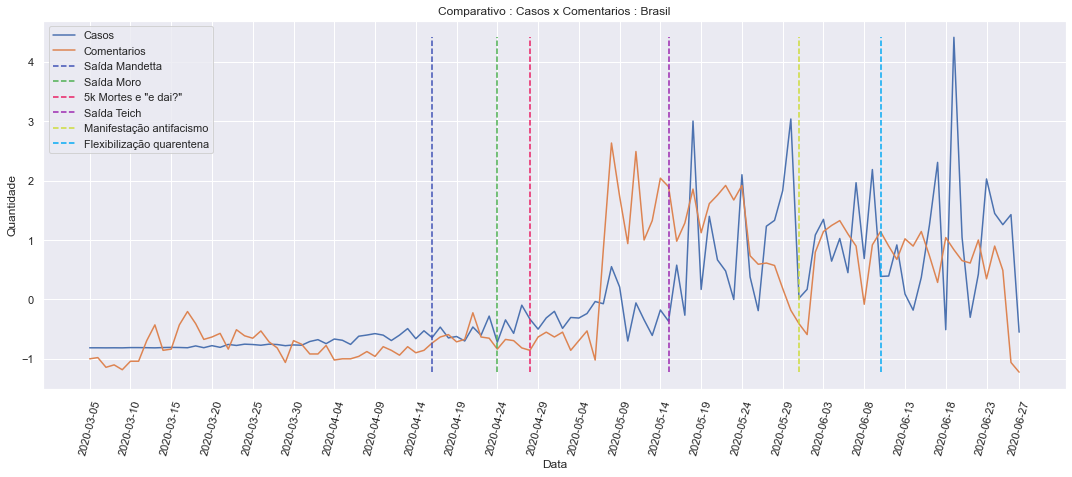

In [169]:
 x1, x2 = gerar_graficos(df_merged["newCases"], df_merged["numComments"], datas, ["Casos", "Comentarios"])

In [170]:
check_time_series(x2, x1, columns=["Comentarios", "Casos"])

Augmented Dickey-Fuller Test:
------------------------------

Comentarios:
------------------------------
ADF Statistic: -1.689244
p-value: 0.436663
Critical Values:
 - 1%: -3.492
 - 5%: -2.888
 - 10%: -2.581
Is the time series stationary? False

Casos:
------------------------------
ADF Statistic: -0.257458
p-value: 0.931317
Critical Values:
 - 1%: -3.494
 - 5%: -2.889
 - 10%: -2.582
Is the time series stationary? False


Engle-Granger Test:
------------------------------
Cointegration Statistic: -3.122671
p-value: 0.083840
Critical Values:
 - 1%: -3.995
 - 5%: -3.39
 - 10%: -3.082
Is time series cointegrate? False


In [171]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])

!!! Can find a model that could fit the series, please make the series stationary !!!


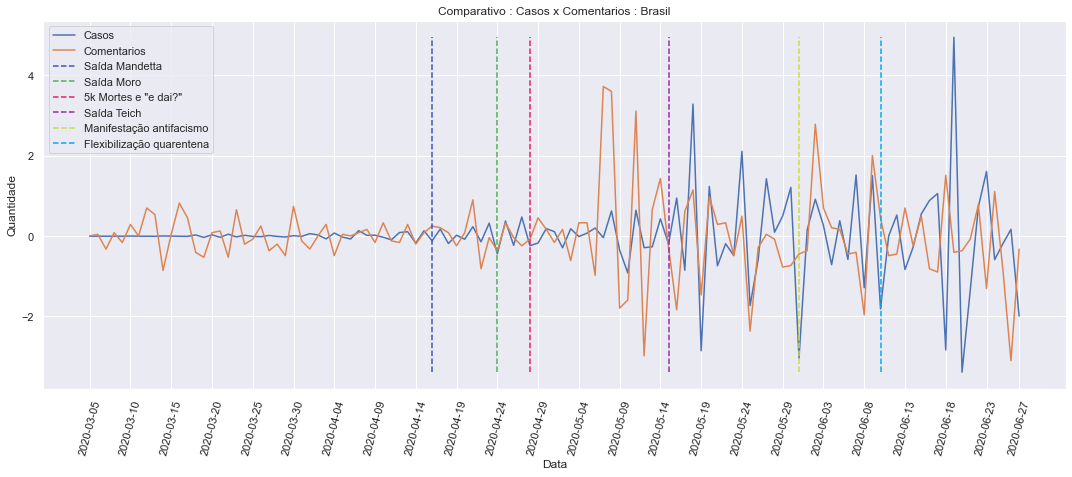

In [172]:
x1, x2 = gerar_graficos(df_merged["stationary_newCases"], df_merged["stationary_numComments"], datas, ["Casos", "Comentarios"])

Vector Error Correction Models (VECM):
------------------------------
Lag: 9
Trend: ct
Cointegration: 2

Granger causality F-test. H_0: Comentarios does not Granger-cause Casos. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value     df   
-----------------------------------------------
         2.620          1.889   0.006 (10, 164)
-----------------------------------------------


Instantaneous causality Wald-test. H_0: Comentarios does not instantaneously cause Casos. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value df
----------------------------------------
        0.5988          3.841   0.439  1
----------------------------------------


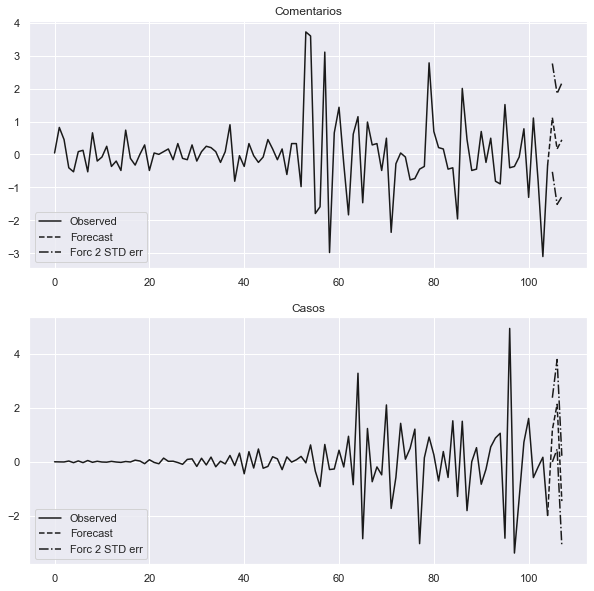

In [173]:
result = autoregression_model(x2, x1, columns=["Comentarios", "Casos"])